In [4]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import pickle

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
basedir = "G:\\My Drive\\Figures\\TwoTower\\SingleSession\\"

In [3]:
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!


In [176]:
def PC_list_maker(mlist,firstSess = None):
    
    FR_dict = {}
    
    FR_dict[0],FR_dict[1]={},{}
    if firstSess is None:
        firstSess = len(mlist)*[5]
    elif isinstance(firstSess,int):
        firstSess = len(mlist)*[firstSess]
    else:
        pass
    
    
    for i, (mouse,f_ind) in enumerate(zip(mlist,firstSess)): 

        df_mouse = df[df['MouseName'].str.match(mouse)]
        for mat_ind,sess_ind in enumerate(np.arange(f_ind,df_mouse.shape[0]).tolist()):
            print("session ind",sess_ind)
            
            sess = df_mouse.iloc[sess_ind]
            VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
            trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)

            S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)
            S_trial_mat[np.isnan(S_trial_mat)]=0
            
            
            
            S_morph_dict = u.trial_type_dict(S_trial_mat,trial_info['morphs'])
            
            S_mu,l = u.across_trial_avg(S_trial_mat,trial_info['morphs'])
            if i==0 and mat_ind==0:
                MU = S_mu
               
            else:
                MU = np.concatenate((MU,S_mu),axis=-1)
                
            
            pc_file = os.path.join(basedir,mouse,"%s_%s_%i" % (sess['Track'],sess['DateFolder'],sess['SessionNumber']),'pc_masks.pkl')
            try:
                with open(pc_file,'rb') as f:
                    masks = pickle.load(f)['masks']
            except:
                masks, FR, SI = pc.place_cells_calc(S, VRDat['pos']._values,trial_info,
                        VRDat['tstart']._values, VRDat['teleport']._values,
                        method='bootstrap',correct_only=False,speed=VRDat.speed._values,
                        win_trial_perm=True,morphlist=[0,1])
                with open(pc_file,'wb') as f:
                    pickle.dump({'masks':masks},f)
                
            fr_dict = pc.plot_placecells(S_morph_dict,masks,plot=False)
            
           
            for sort in [0,1]:
                for m in [0,.25,.5,.75,1.]:
                    if i==0 and mat_ind == 0:
                        
                        FR_dict[sort][m] = fr_dict[sort][m]
                    else:
                        FR_dict[sort][m]=np.concatenate((FR_dict[sort][m],fr_dict[sort][m]),axis=0)
    return FR_dict, MU
           
    

In [174]:
Rare_dict, Rare_mu = PC_list_maker(['4139265.5','4139265.4','4139265.3'])
Fam_dict, Fam_mu=PC_list_maker(['4222153.2','4222153.3','4222153.1','4222174.1'],firstSess=4)

session ind 5
num aberrant ttls 0.0
34737 (34737,) (34737, 21) 113863


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0
[[[103.1808277    7.54989808   5.20089978 ...  23.15294005   9.25085185
    10.5251895 ]
  [ 19.12726034   3.58157498  13.84936741 ...  11.92037283   9.1207788
     6.34086523]
  [  3.03587825   2.19110397  15.70240267 ...   7.52596674   9.41557118
     7.01483167]
  ...
  [  0.           7.94023533   4.42682779 ...   4.80475432   8.28157161
     6.67416919]
  [  0.           6.91913858   5.04630879 ...   3.2138765    7.44100927
     1.94657648]
  [  0.          17.91667861   4.56584899 ...  11.05608664   7.12654204
     0.55113508]]

 [[184.76698837   3.39820279  10.27890342 ...  28.12732306  17.18252749
     6.9887043 ]
  [ 43.15640154  11.85164066   3.44465032 ...   5.93730502   4.44224389
     5.64871907]
  [  4.3588309    7.60994214  13.89178486 ...   2.1678957   12.46111832
     5.10207123]
  ...
  [  3.16630268   6.82742752   8.77382154 ...   5.5497458    2.84117386
     1.13078966]
  [  1.73172076   1.08217143   0.58072625 ...   9.29957914  16.3618758
     9.314903

In [107]:
def pop_PC_plot(FR_dict):
    f,ax = plt.subplots(2,5,figsize=[15,9])
    getSort = lambda fr : np.argsort(np.argmax(np.squeeze(fr),axis=1))
    sort0= getSort(FR_dict[0][0])
    sort1 = getSort(FR_dict[1][1])
    for i,sort in enumerate([sort0,sort1]):
        for j,m in enumerate([0,.25,.5,.75,1]):
            ax[i,j].imshow(FR_dict[i][m][sort,:],aspect='auto',cmap='pink',vmin=0.2,vmax=.9)
    return f,ax

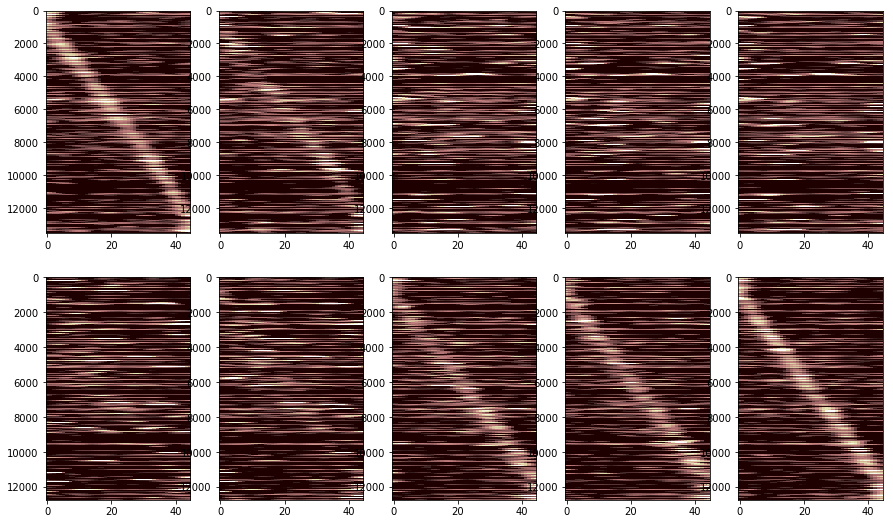

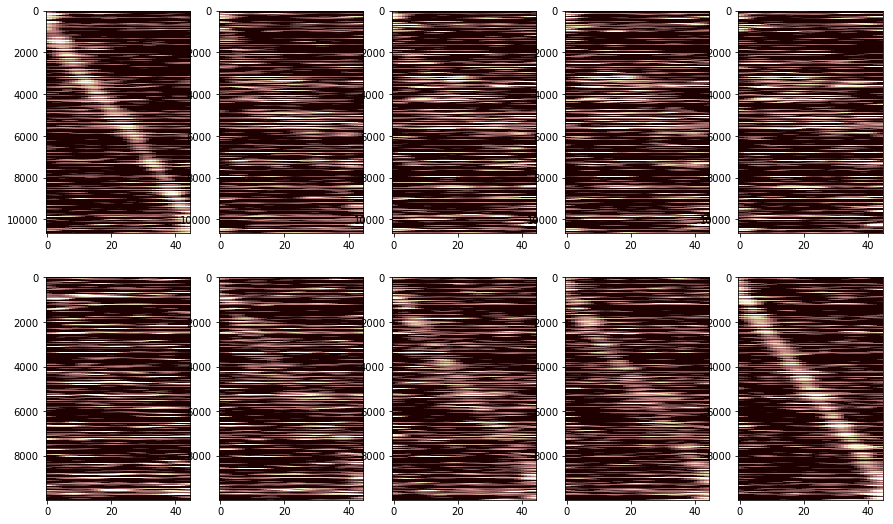

In [112]:
f_rare,ax_rare = pop_PC_plot(Rare_dict)

f_fam,ax_fam = pop_PC_plot(Fam_dict)

[[1.         0.47722539 0.12938403 0.10476592 0.10955906]
 [0.47722539 1.         0.23103226 0.19467405 0.20359598]
 [0.12938403 0.23103226 1.         0.54409741 0.57010471]
 [0.10476592 0.19467405 0.54409741 1.         0.62088072]
 [0.10955906 0.20359598 0.57010471 0.62088072 1.        ]]
[[1.         0.45027216 0.31543462 0.28288621 0.271754  ]
 [0.45027216 1.         0.51267394 0.47338618 0.4569724 ]
 [0.31543462 0.51267394 1.         0.60775598 0.59962227]
 [0.28288621 0.47338618 0.60775598 1.         0.62765149]
 [0.271754   0.4569724  0.59962227 0.62765149 1.        ]]


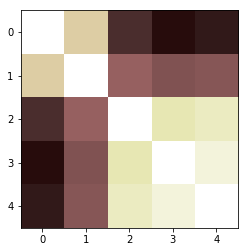

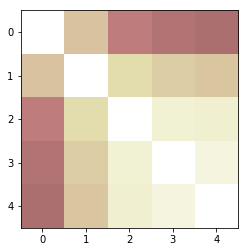

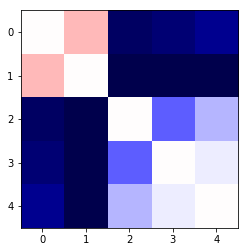

In [188]:

def mean_FR_corr(MU):
    MU_z = sp.stats.zscore(MU,axis=-1)
    mu_sim = np.matmul(np.transpose(MU_z,axes=[1,0,2]),np.transpose(MU_z,axes=[1,2,0])).mean(axis=0)/MU_z.shape[2]
    print(mu_sim)
#     MU_f = MU.reshape([MU.shape[0],-1])
#     MU_f[np.isnan(MU_f)]=0
#     MU_f /= np.linalg.norm(MU_f,2,axis=1)[:,np.newaxis]
#     MU_f[np.isnan(MU_f)]=0
#     mu_sim = np.matmul(MU_f,MU_f.T)
#     print(mu_sim)
    f,ax = plt.subplots()
    ax.imshow(mu_sim,cmap='pink',vmin=.1,vmax=.7)
    return mu_sim

rare_mu_sim = mean_FR_corr(Rare_mu)
fam_mu_sim = mean_FR_corr(Fam_mu)

f,ax = plt.subplots()
ax.imshow(rare_mu_sim-fam_mu_sim,cmap='seismic',vmin=-.2,vmax=.2)

In [113]:
f_rare.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers\\Figures\\AllPlaceCells_Rare.pdf",format='pdf')
f_fam.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers\\Figures\\AllPlaceCells_Fam.pdf",format='pdf')

[[], []]
